In [1]:
pip install torchtext==0.8.0

     |████████████████████████████████| 6.9MB 13.5MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [2]:
import torch
import torch.nn as nn
from torchtext.data.metrics import bleu_score
import torch.optim as optim
import torch.nn.functional as F
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
import matplotlib.pyplot as plt
import tqdm
import matplotlib.ticker as ticker
import spacy
import numpy as np

In [3]:
!python -m spacy download de

     |████████████████████████████████| 14.9MB 26.1MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907057 sha256=7c1e85b51ed465cd68d3dfe8c35f9624bc0fb0a9fc23ded81a1c5fe0319ed952
  Stored in directory: /tmp/pip-ephem-wheel-cache-3g0wlg76/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [4]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [5]:
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [6]:
SRC = Field(tokenize = tokenize_de, init_token = '<sos>', eos_token = '<eos>', lower = True, batch_first = True)
TRG = Field(tokenize = tokenize_en, init_token = '<sos>', eos_token = '<eos>', lower = True, batch_first = True)

/usr/local/lib/python3.6/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [7]:
train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'), fields=(SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 966kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 276kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 262kB/s]
/usr/local/lib/python3.6/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [8]:
SRC.build_vocab(train_data, max_size=10000, min_freq = 2)
TRG.build_vocab(train_data, max_size=10000, min_freq = 2)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128

In [10]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data), batch_size=batch_size, 
                                                                      sort_within_batch=True, sort_key=lambda x: len(x.src),
                                                                      device=device)

/usr/local/lib/python3.6/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [11]:
for batch in train_iterator:
    ger = batch.src
    eng = batch.trg
    print(eng.shape, ger.shape)
    break

/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


torch.Size([128, 25]) torch.Size([128, 16])


In [12]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, num_layers, kernel_size, p, device, max_length = 100):
        super().__init__()
        assert kernel_size % 2 == 1, "Invalid kernel size!"

        self.device = device
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        self.dropout = nn.Dropout(p)

        self.word_embedding = nn.Embedding(input_dim, emb_dim)
        self.positional_embedding = nn.Embedding(max_length, emb_dim)
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)

        self.conv_layers = nn.ModuleList([nn.Conv1d(in_channels=hid_dim, out_channels=hid_dim * 2, kernel_size=kernel_size, 
                                                    padding=(kernel_size - 1) // 2) for _ in range(num_layers)])
    
    def forward(self, src):
        batch_size, src_len = src.shape
        positions = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        word_embedded = self.word_embedding(src)
        position_embedded = self.positional_embedding(positions)
        embedded = self.dropout(word_embedded + position_embedded)

        conv_input = self.emb2hid(embedded)
        conv_input = conv_input.permute(0, 2, 1)

        for conv in self.conv_layers:
            conved = conv(self.dropout(conv_input))
            conved = F.glu(conved, dim=1)
            conved = self.scale * (conved + conv_input)
            conv_input = conved

        conved = self.hid2emb(conved.permute(0, 2, 1))
        combined = self.scale * (conved + embedded)

        return conved, combined

In [13]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, num_layers, kernel_size, p, trg_pad_idx, device, max_length = 100):
        super().__init__()
        self.device = device
        self.kernel_size = kernel_size
        self.trg_pad_idx = trg_pad_idx
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        self.dropout = nn.Dropout(p)

        self.word_embedding = nn.Embedding(output_dim, emb_dim)
        self.positional_embedding = nn.Embedding(max_length, emb_dim)
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)

        self.attn_emb2hid = nn.Linear(emb_dim, hid_dim)
        self.attn_hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.conv_layers = nn.ModuleList([nn.Conv1d(in_channels=hid_dim, out_channels=2 * hid_dim, 
                                                    kernel_size=kernel_size) for _ in range(num_layers)])
        
        self.fc_out = nn.Linear(emb_dim, output_dim)

    def get_attention(self, embedded, conved, enc_conved, enc_combined):
        conved_emb = self.attn_hid2emb(conved.permute(0, 2, 1))
        combined = self.scale * (embedded + conved_emb)

        energy = torch.matmul(combined, enc_conved.permute(0 ,2, 1))
        attention = F.softmax(energy, dim=2)

        attention_encoding = torch.matmul(attention, enc_combined)
        attention_encoding = self.attn_emb2hid(attention_encoding)
        attention_combined = self.scale * (conved + attention_encoding.permute(0, 2, 1))

        return attention, attention_combined

    def forward(self, trg, enc_conved, enc_combined):
        batch_size, trg_len = trg.shape
        positions = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        word_embedded = self.word_embedding(trg)
        position_embedded = self.positional_embedding(positions)
        embedded = self.dropout(word_embedded + position_embedded)

        conv_input = self.emb2hid(embedded)
        conv_input = conv_input.permute(0, 2, 1)
        hid_dim = conv_input.shape[1]
        
        for conv in self.conv_layers:
            conv_input = self.dropout(conv_input)
            padding = torch.zeros(batch_size, hid_dim, self.kernel_size-1).fill_(self.trg_pad_idx).to(self.device)
            padded_conv_input = torch.cat((padding, conv_input), dim=2)

            conved = conv(padded_conv_input)
            conved = F.glu(conved, dim=1)

            attention, conved = self.get_attention(embedded, conved, enc_conved, enc_combined)
            conved = self.scale * (conv_input + conved)
            conv_input = conved

        conved = self.hid2emb(conved.permute(0, 2, 1))
        output = self.fc_out(self.dropout(conved))

        return output, attention

In [14]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.enc = encoder
        self.dec = decoder

    def forward(self, src, trg):
        enc_conved, enc_combined = self.enc(src)
        output, attention = self.dec(trg, enc_conved, enc_combined)

        return output, attention

In [15]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EPOCHS = 16
CLIP = 0.1
EMB_DIM = 256
HID_DIM = 512 
ENC_LAYERS = 10 
DEC_LAYERS = 10 
ENC_KERNEL_SIZE = 3 
DEC_KERNEL_SIZE = 3 
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

In [16]:
encoder = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device)
decoder = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device)

In [17]:
net = Seq2Seq(encoder, decoder).to(device)
net

Seq2Seq(
  (enc): Encoder(
    (dropout): Dropout(p=0.25, inplace=False)
    (word_embedding): Embedding(7855, 256)
    (positional_embedding): Embedding(100, 256)
    (emb2hid): Linear(in_features=256, out_features=512, bias=True)
    (hid2emb): Linear(in_features=512, out_features=256, bias=True)
    (conv_layers): ModuleList(
      (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (8): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
   

In [18]:
opt = optim.Adam(net.parameters())
loss_fn = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

In [19]:
def translate(sentence, src_field, trg_field, net, device, max_len=50):
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    with torch.no_grad():
        enc_conved, enc_combined = net.enc(src_tensor)
    
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for _ in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        with torch.no_grad():
            output, attention = net.dec(trg_tensor, enc_conved, enc_combined)
        
        pred_token = output.argmax(2)[:, -1].item()
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [31]:
def bleu(data, net, src_field, trg_field, device):
    targets = []
    outputs = []

    for d in data:
        src = vars(d)["src"]
        trg = vars(d)["trg"]

        prediction, _ = translate(src, src_field, trg_field, net, device)
        prediction = prediction[:-1]  

        targets.append([trg])
        outputs.append(prediction)
       
    return bleu_score(outputs, targets)

In [21]:
def save_checkpoint(net, opt, losses, filename):
    check_point = {"net_dict": net.state_dict(), "opt_dict": opt.state_dict(), "losses": losses}
    torch.save(check_point, filename)
    print("Checkpoint Saved!")

def load_checkpoint(net, opt, filename):
    check_point = torch.load(filename)
    net.load_state_dict(check_point["net_dict"])
    opt.load_state_dict(check_point["opt_dict"])
    losses = check_point["losses"]
    print("Checkpoint Loaded!")

In [22]:
t = [[['that', 'is', 'a', 'plane', 'and', 'not', 'a', 'bird']]]
o = [['that', 'is', 'a', 'plane', 'and', 'not', 'a', 'dog']]
bleu_score(o, t)

0.8408964276313782

In [23]:
text = "ein boot mit mehreren männern darauf wird von einem großen pferdegespann ans ufer gezogen"
english_translation = "a boat with several men on it is being pulled ashore by a large team of horses"

In [24]:
losses = []

In [25]:
for epoch in range(EPOCHS):
    batch_losses = []
    for batch in tqdm.tqdm(train_iterator, total=len(train_iterator)):
        X = batch.src.to(device)
        y = batch.trg.to(device)

        output, _ = net(X, y[:, :-1])
        output = output.contiguous().view(-1, output.shape[-1])
        y = y[:, 1:].contiguous().view(-1)
        
        opt.zero_grad()
        loss = loss_fn(output, y)
        loss.backward()
        batch_losses.append(loss.item())
        torch.nn.utils.clip_grad_norm_(net.parameters(), CLIP)
        opt.step()

    losses.append(np.round(sum(batch_losses)/len(batch_losses), 5))
    print(f" Epoch: {epoch} | Loss: {losses[epoch]:4f}")

    pred_list, _ = translate(text, SRC, TRG, net, device)
    pred_text = ""
    for word in pred_list:
        pred_text += word + " "

    print(pred_text)
    print("")

    if epoch % 5 == 0:
        save_checkpoint(net, opt, losses, f"checkpoint-{epoch}.pth.tar")
        print("")

  0%|          | 0/227 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
100%|██████████| 227/227 [00:36<00:00,  6.21it/s]


 Epoch: 0 | Loss: 4.218160
a boat with a blue is is walking off a large <unk> . <eos> 



  0%|          | 0/227 [00:00<?, ?it/s]

Checkpoint Saved!



100%|██████████| 227/227 [00:37<00:00,  6.08it/s]


 Epoch: 1 | Loss: 2.973500


  0%|          | 0/227 [00:00<?, ?it/s]

a boat with a orange . <eos> 



100%|██████████| 227/227 [00:37<00:00,  5.99it/s]


 Epoch: 2 | Loss: 2.555540


  0%|          | 1/227 [00:00<00:35,  6.30it/s]

a boat with several men is being being of a large <unk> of <unk> . <eos> 



100%|██████████| 227/227 [00:38<00:00,  5.90it/s]


 Epoch: 3 | Loss: 2.332130


  0%|          | 0/227 [00:00<?, ?it/s]

a boat with a brown and white is being chased . <eos> 



100%|██████████| 227/227 [00:39<00:00,  5.82it/s]


 Epoch: 4 | Loss: 2.179730


  0%|          | 1/227 [00:00<00:35,  6.29it/s]

a boat with several men is being by a large <unk> - white - white and white men . <eos> 



100%|██████████| 227/227 [00:39<00:00,  5.78it/s]


 Epoch: 5 | Loss: 2.077930
a boat with several men on the cheek of a large <unk> of shore . <eos> 



  0%|          | 0/227 [00:00<?, ?it/s]

Checkpoint Saved!



100%|██████████| 227/227 [00:39<00:00,  5.72it/s]


 Epoch: 6 | Loss: 1.989690


  0%|          | 0/227 [00:00<?, ?it/s]

a boat with several men is being carried by a large bank of shore . <eos> 



100%|██████████| 227/227 [00:39<00:00,  5.71it/s]


 Epoch: 7 | Loss: 1.924660


  0%|          | 1/227 [00:00<00:41,  5.39it/s]

a boat with several men is being being pulled by a large pot of trees . <eos> 



100%|██████████| 227/227 [00:40<00:00,  5.67it/s]


 Epoch: 8 | Loss: 1.869900


  0%|          | 1/227 [00:00<00:42,  5.32it/s]

a boat with several men is being pulled by a large <unk> of the other . <eos> 



100%|██████████| 227/227 [00:40<00:00,  5.66it/s]


 Epoch: 9 | Loss: 1.820620


  0%|          | 0/227 [00:00<?, ?it/s]

a boat with several men partially by a large <unk> covered boat . <eos> 



100%|██████████| 227/227 [00:40<00:00,  5.65it/s]


 Epoch: 10 | Loss: 1.781540
a boat with several men is being pulled by a large metal <unk> . <eos> 



  0%|          | 0/227 [00:00<?, ?it/s]

Checkpoint Saved!



100%|██████████| 227/227 [00:40<00:00,  5.63it/s]


 Epoch: 11 | Loss: 1.744750


  0%|          | 1/227 [00:00<00:40,  5.54it/s]

a boat with several men is being getting by a large metal <unk> . <eos> 



100%|██████████| 227/227 [00:40<00:00,  5.64it/s]


 Epoch: 12 | Loss: 1.710200


  0%|          | 0/227 [00:00<?, ?it/s]

a boat with several men is being served by a large <unk> - trees . <eos> 



100%|██████████| 227/227 [00:40<00:00,  5.65it/s]


 Epoch: 13 | Loss: 1.680850


  0%|          | 1/227 [00:00<00:36,  6.24it/s]

a boat boat several several men are being pulled by a large <unk> of the <unk> . <eos> 



100%|██████████| 227/227 [00:40<00:00,  5.63it/s]


 Epoch: 14 | Loss: 1.651700


  0%|          | 0/227 [00:00<?, ?it/s]

a boat with several men on it being <unk> safe . <eos> 



100%|██████████| 227/227 [00:40<00:00,  5.62it/s]


 Epoch: 15 | Loss: 1.623750
a boat with several men is being pulled by a large <unk> shoreline . <eos> 

Checkpoint Saved!



Text(0, 0.5, 'loss')

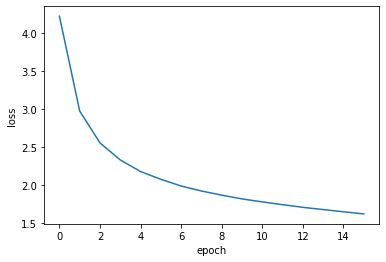

In [26]:
plt.plot(losses)
plt.xlabel("epoch")
plt.ylabel("loss")

In [27]:
len(test_data)

1000

In [32]:
score = bleu(test_data, net, SRC, TRG, device) * 100
print(f"Bleu Score: {score}")

Bleu Score: 31.03945411400113


In [33]:
# bleu score interpretation:
# 0 - 19: bad translations
# 20 - 29: understandable translations
# 30 - 39: good translations
# 40 - 49: High quality translations
# 50 - 60: Very high quality, adequate, and fluent translations
# > 60: Quality often better than human

In [56]:
def display_attention(sentence, translation, attention):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    attention = attention.squeeze(0).cpu().detach().numpy()
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels([''] + ['<sos>'] + [t.text.lower() for t in spacy_de.tokenizer(sentence)] + ['<eos>'], 
                       rotation=45)
    ax.set_yticklabels([''] + translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [72]:
text1 = "Ein Mann geht die Straße entlang, während er eine Tasse in der Hand hält"
og_translation1 = "a man is walking down the street while holding a cup"

In [73]:
pred_list, attention = translate(text1, SRC, TRG, net, device)
pred_text = ""
for word in pred_list:
    pred_text += word + " "

print(pred_text)
print("")

a man is walking down the street while holding a cup of art . <eos> 



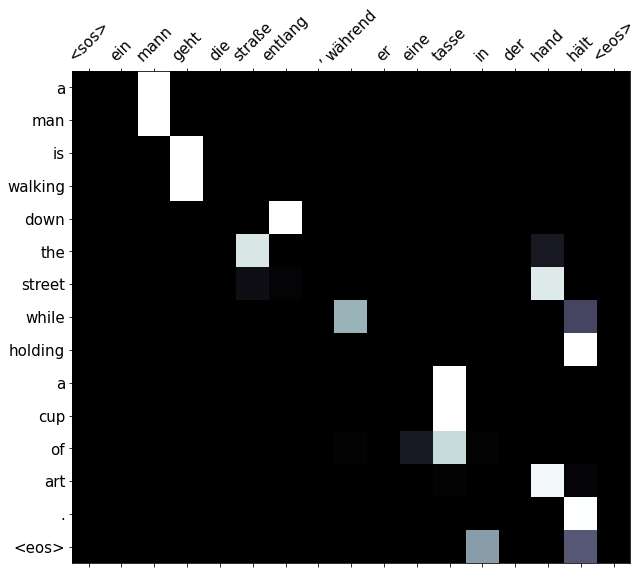

In [74]:
display_attention(text1, pred_list, attention)

In [69]:
text2 = "Dieser Affe klettert auf einen Baum"
og_translation2 = "that monkey is climbing a tree"

In [70]:
pred_list, attention = translate(text2, SRC, TRG, net, device)
pred_text = ""
for word in pred_list:
    pred_text += word + " "

print(pred_text)
print("")

this <unk> is climbing a tree . <eos> 



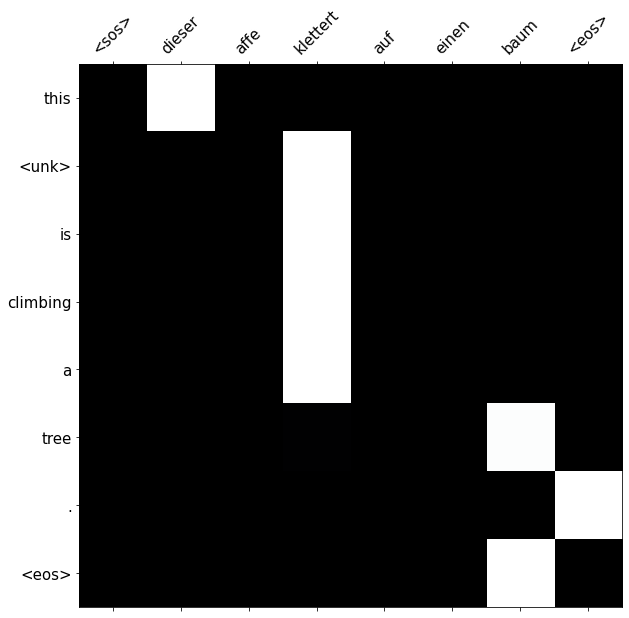

In [71]:
display_attention(text2, pred_list, attention)

In [66]:
text3 = "Dieser Mann rennt zu langsam, um den Bus zu erreichen"
og_translation3 = "that man is running too slow to catch the bus"

In [67]:
pred_list, attention = translate(text3, SRC, TRG, net, device)
pred_text = ""
for word in pred_list:
    pred_text += word + " "

print(pred_text)
print("")

this man is running towards the bus to reach the bus . <eos> 



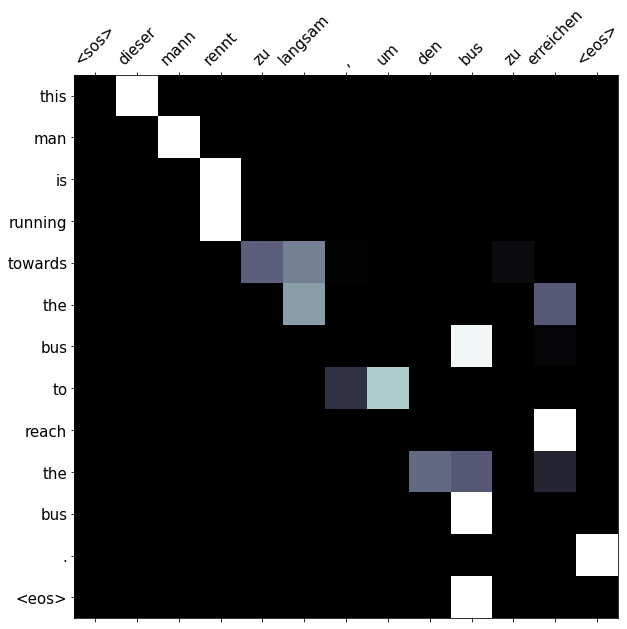

In [68]:
display_attention(text3, pred_list, attention)